In [ ]:
!pip install torch torchvision matplotlib

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),              # Converts to [0,1]
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 503kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.70MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 14.8MB/s]


In [5]:
batch_size = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

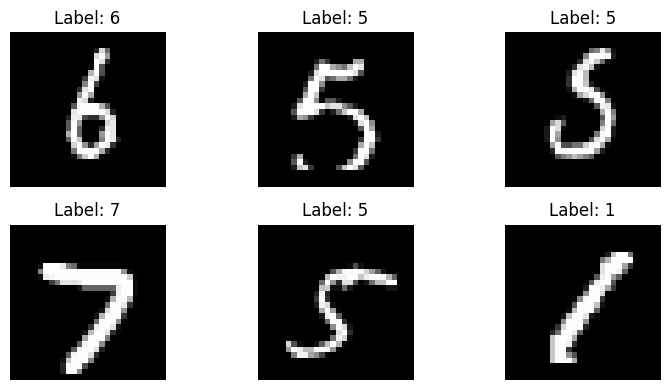

In [6]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

plt.figure(figsize=(8,4))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
    plt.title(f"Label: {example_targets[i].item()}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [12]:
class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)

        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.25)

        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout(x)

        x = x.view(x.size(0), -1)

        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x


In [13]:
model = MNIST_CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)

MNIST_CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [9]:
def train(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(loader)

In [10]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [14]:
epochs = 5

for epoch in range(epochs):
    train_loss = train(model, train_loader, optimizer, criterion)
    test_acc = evaluate(model, test_loader)

    print(f"Epoch [{epoch+1}/{epochs}]")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Test Accuracy: {test_acc*100:.2f}%\n")

Epoch [1/5]
Train Loss: 0.1206
Test Accuracy: 98.50%

Epoch [2/5]
Train Loss: 0.0433
Test Accuracy: 98.73%

Epoch [3/5]
Train Loss: 0.0272
Test Accuracy: 98.87%

Epoch [4/5]
Train Loss: 0.0191
Test Accuracy: 99.12%

Epoch [5/5]
Train Loss: 0.0155
Test Accuracy: 98.75%



In [15]:
model_path = "mnist_cnn.pt"
torch.save(model.state_dict(), model_path)

print(f"Model saved to {model_path}")

Model saved to mnist_cnn.pt


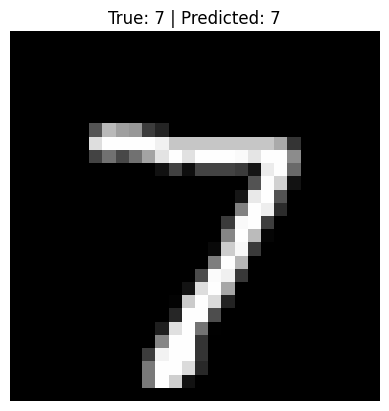

In [16]:
model.eval()

image, label = test_dataset[0]
image = image.unsqueeze(0).to(device)

with torch.no_grad():
    output = model(image)
    prediction = torch.argmax(output, dim=1).item()

plt.imshow(image.cpu()[0][0], cmap='gray')
plt.title(f"True: {label} | Predicted: {prediction}")
plt.axis('off')
plt.show()